#Full Pipeline: Violin vs Viola Classification
This master notebook runs the entire pipeline.

## TODO:
In "Load and Process URMP Violin and Viola recordings from drive:"

TODO: Unzip the ViolinViolaData file and make sure the directory in your drive is as follows:

/content/drive/My Drive/ViolinViolaData/Violin-URMP/

/content/drive/My Drive/ViolinViolaData/Viola-URMP/

that way, the following block runs:

```
!cp -r "/content/drive/My Drive/ViolinViolaData/Violin-URMP/"* data/raw/Violin_URMP/
!cp -r "/content/drive/My Drive/ViolinViolaData/Viola-URMP/"*  data/raw/Viola_URMP/
```
or, replace the path with your Violin-URMP and Viola-URMP locations in Google Drive

## Versions:

```
Python version: 3.11.12
numpy version: 2.0.2
librosa version: 0.11.0
scikit-learn version: 1.6.1
matplotlib version: 3.10.0
pandas version: 2.2.2
tqdm version: 4.67.1
joblib version: 1.5.0
```

In [29]:
# Remove any existing folder, then clone fresh
!rm -rf ViolinViolaClassifier
!git clone https://github.com/JooshJin/ViolinViolaClassifier.git
%cd ViolinViolaClassifier

# Install dependencies
!pip install yt-dlp librosa scikit-learn matplotlib resampy

Cloning into 'ViolinViolaClassifier'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 152 (delta 79), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 55.35 KiB | 2.91 MiB/s, done.
Resolving deltas: 100% (79/79), done.
/content/ViolinViolaClassifier/ViolinViolaClassifier/ViolinViolaClassifier/ViolinViolaClassifier


## Setup Python Path and Imports

In [30]:
import os, sys
# Ensure src/ is on Python path
sys.path.insert(0, os.path.abspath('src'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, warnings
from data_utils import download_full_audio_api, segment_audio, segment_stems, load_processed_dataset, load_manifests
from features import extract_features_folder
from models import LogisticRegressionGD, Perceptron, LinearSVM
from evaluation import train_test_split_and_evaluate

warnings.filterwarnings(action='ignore')
np.random.seed(1)

## Prepare Output Directories

In [31]:
# Create data and output dirs
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

## Load Manifests

In [32]:
ids, stamps = load_manifests(
    'solos_ids_filtered.json',
    'solos_timestamps_filtered.json'
)
print(f"Solos dataset Violin clips: {len(ids['Violin'])}, Viola clips: {len(ids['Viola'])}")


#DOWNLOAD AND PREPROCESS SOLOS DATASET AUDIOS:

download_full_audio_api(ids, out_dir='data/raw_full')
segment_audio(ids, stamps, raw_dir='data/raw_full', out_dir='data/processed', sr=22050)
#check if audios are there
print("Processed clips:")
print("  Violin:", len(os.listdir('data/processed/Violin')))
print("  Viola: ", len(os.listdir('data/processed/Viola')))

print("  sample Violin:", os.listdir('data/processed/Violin')[:5])
print("  sample Viola: ", os.listdir('data/processed/Viola')[:5])

Solos dataset Violin clips: 6, Viola clips: 19
Downloaded & converted: JrNn2Ns7k-g
Downloaded & converted: m-KysGSYBj4
Downloaded & converted: XD7sLDv-RcY
Downloaded & converted: R-nCclzJnoo
Downloaded & converted: urn_s6PHvz0
Downloaded & converted: XuavXLTeG84
Downloaded & converted: -fTiMdxqL1o
Downloaded & converted: 4KujFOTKzN0
Downloaded & converted: 80pVi2NQ66c
Downloaded & converted: IGCx-Bdi-50
Downloaded & converted: SOU5JJ_sPh4
Downloaded & converted: SsbB7f_Z-io
Downloaded & converted: WZgPcjChMsY
Downloaded & converted: _fp_jfzBgts
Downloaded & converted: hjvtVopqflI
Downloaded & converted: jvZgxmVGR4A
Downloaded & converted: lLml8_BjQO8
Downloaded & converted: p0CzWz7DzVo
Downloaded & converted: 74k3q8_VrBg
Downloaded & converted: sqxJKwgf7ZU
Downloaded & converted: 7prjR3U2wKs
Downloaded & converted: cX4lzxo5z1M
Downloaded & converted: rHFcx82rEcY
Downloaded & converted: GLbJIvNb4Bk
Downloaded & converted: 5gXhWO8psRE&t=626s
Saved JrNn2Ns7k-g_0.wav [8.0s–101.0s]
Saved Jr

## Preprocessing Solos data

In [33]:
# chop extracted Solos WAVs into 10s clips
segment_stems('data/processed/Violin',
              'data/processed/Violin',
              sr=22050,
              clip_dur=10.0)

segment_stems('data/processed/Viola',
              'data/processed/Viola',
              sr=22050,
              clip_dur=10.0)

## Load and Process URMP Violin and Viola recordings from drive

In [34]:
from google.colab import drive
drive.mount('/content/drive')

# Make sure target dirs exist
!mkdir -p data/raw/Violin_URMP data/raw/Viola_URMP

# Copy all WAVs from YOUR Drive folders into them
# TODO: either ensure the paths are correct in your drive or replace these with the correct path to the two files.
!cp -r "/content/drive/My Drive/ViolinViolaData/Violin-URMP/"* data/raw/Violin_URMP/
!cp -r "/content/drive/My Drive/ViolinViolaData/Viola-URMP/"*  data/raw/Viola_URMP/

segment_stems('data/raw/Violin_URMP', 'data/processed/Violin', sr=22050, clip_dur=10.0)
segment_stems('data/raw/Viola_URMP',  'data/processed/Viola',  sr=22050, clip_dur=10.0)

print("Processed Violin clips:", len(os.listdir('data/processed/Violin')))
print("Processed Viola clips: ", len(os.listdir('data/processed/Viola')))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processed Violin clips: 701
Processed Viola clips:  677


## Feature Extraction

In [35]:
X, y = extract_features_folder(
    folder='data/processed',
    sr=22050,
    clip_duration=10.0,
    min_rms=1e-4      # skip any clip with RMS energy < 0.0001
)

print(f"After RMS filtering, extracted features shape: {X.shape}")

import numpy as np
uniq, counts = np.unique(y, return_counts=True)
for label, count in zip(uniq, counts):
    name = 'Violin' if label == 1 else 'Viola'
    print(f"   • {name}: {count} clips")


After RMS filtering, extracted features shape: (1378, 64)
   • Viola: 677 clips
   • Violin: 701 clips


## Train and Evaluate Classifier

changed from hard-set weights to balanced weights

In [36]:
from sklearn.preprocessing import StandardScaler
from collections import Counter

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# balance class weights (so each class contributes equally)
counts = Counter(y)
total  = sum(counts.values())
class_weight = {cls: total/(2*counts[cls]) for cls in counts}

print("Using class weights:", class_weight)

# weighted logistic‐GD
clf = LogisticRegressionGD(
    lr=0.01,
    epochs=1000,
    lam=0.1,
    class_weight=class_weight
)

# Train & evaluate on the scaled data
metrics = train_test_split_and_evaluate(
    X_scaled, y, clf,
    test_size=0.2,
    random_state=42,
)
print(metrics)


Using class weights: {np.int64(0): 1.017725258493353, np.int64(1): 0.9828815977175464}
{'accuracy': 0.9057971014492754, 'precision': 0.9596774193548387, 'recall': 0.85, 'f1': 0.9015151515151515, 'confusion_matrix': [[131, 5], [21, 119]]}


## Save Metrics and Confusion Matrix


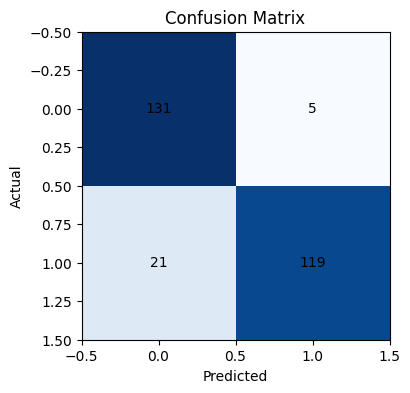

In [37]:
# Save metrics to CSV
pd.DataFrame([metrics]).to_csv('outputs/metrics.csv', index=False)

# Plot and save confusion matrix
cm = np.array(metrics['confusion_matrix'])
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.savefig('outputs/confusion_matrix.png')
plt.show()


## Testing and Scoring All Three Models

Using class weights: {np.int64(0): 1.017725258493353, np.int64(1): 0.9828815977175464}

=== Logistic Regression ===
Accuracy:  0.906
Precision: 0.960
Recall:    0.850
F1 score:  0.902


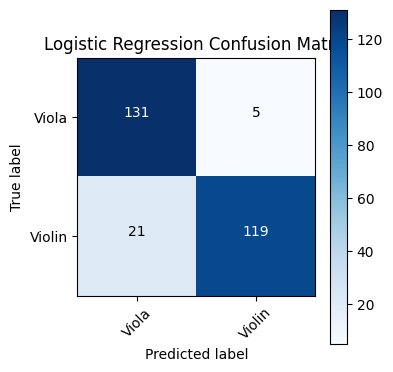


=== Perceptron ===
Accuracy:  0.971
Precision: 0.978
Recall:    0.964
F1 score:  0.971


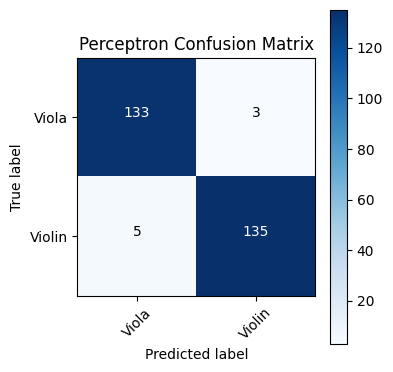


=== Linear SVM ===
Accuracy:  0.884
Precision: 0.950
Recall:    0.814
F1 score:  0.877


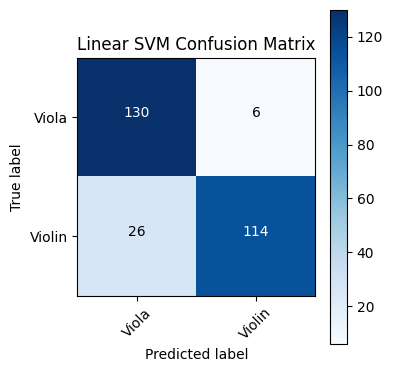

In [38]:
from sklearn.preprocessing import StandardScaler
from collections import Counter
from models import LogisticRegressionGD, Perceptron, LinearSVM
from evaluation import train_test_split_and_evaluate, plot_confusion_matrix

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

counts = Counter(y)
total  = sum(counts.values())
class_weight = {cls: total/(2 * counts[cls]) for cls in counts}

print("Using class weights:", class_weight)

# 3 weighted models
classifiers = {
    "Logistic Regression": LogisticRegressionGD(
        lr=0.01, epochs=1000, lam=0.1, class_weight=class_weight
    ),
    "Perceptron": Perceptron(
        lr=0.01, epochs=1000, class_weight=class_weight
    ),
    "Linear SVM": LinearSVM(
        lr=0.001, epochs=1000, C=1.0, class_weight=class_weight
    )
}

# train, evaluate, and plot one at a time on the scaled data
for name, clf in classifiers.items():
    print(f"\n=== {name} ===")
    metrics = train_test_split_and_evaluate(
        X_scaled, y, clf,
        test_size=0.2,
        random_state=42
    )
    print(f"Accuracy:  {metrics['accuracy']:.3f}")
    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall:    {metrics['recall']:.3f}")
    print(f"F1 score:  {metrics['f1']:.3f}")

    # plot its confusion matrix
    cm = metrics["confusion_matrix"]
    plot_confusion_matrix(
        cm,
        classes=["Viola", "Violin"],
        title=f"{name} Confusion Matrix",
        normalize=False
    )

## Plotting the PCA projection

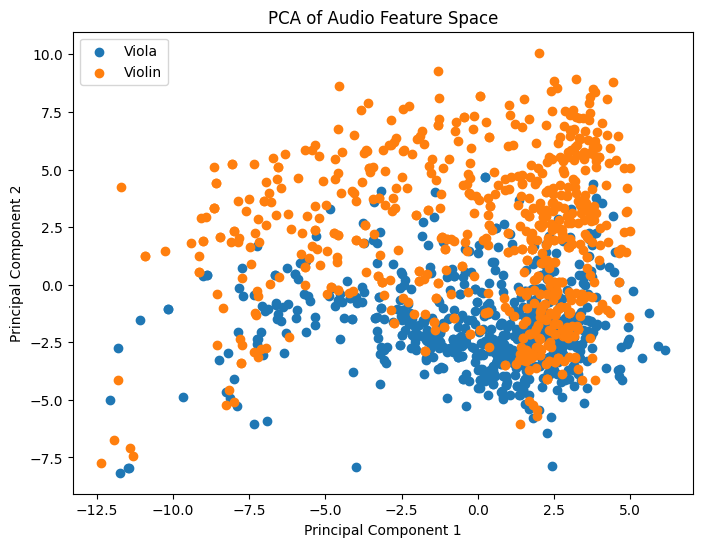

PC1 explains 19.42% of the total variance
PC2 explains 16.92% of the total variance


In [39]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# plot
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    mask = (y == label)
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=('Viola' if label == 0 else 'Violin'))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Audio Feature Space')
plt.legend()
plt.show()

ratios = pca.explained_variance_ratio_
print(f"PC1 explains {ratios[0]*100:.2f}% of the total variance")
print(f"PC2 explains {ratios[1]*100:.2f}% of the total variance")


# DEMO: Violin vs Viola Classifier
### Choose between the three models to predict if your WAV file is a violin or viola recording

In [40]:
# === Demo: Upload, classify & show confidence in Colab ===

from google.colab import files
import io, numpy as np
import soundfile as sf
import librosa
import resampy

###############################
###### SELECT YOUR MODEL ######
###############################
selected_model = "Logistic Regression"  # Options: 'Logistic Regression', 'Perceptron', 'Linear SVM'
clf = classifiers[selected_model]

print(f"VIOLIN VIOLA CLASSIFIER ({selected_model})")
print("Upload .wav files (10 s or longer recommended).")
uploads = files.upload()

def extract_features(wav, sr):
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
    mf = np.hstack([mfcc.mean(axis=1), mfcc.std(axis=1)])
    chrom = librosa.feature.chroma_stft(y=wav, sr=sr)
    ch = np.hstack([chrom.mean(axis=1), chrom.std(axis=1)])
    spec = librosa.feature.spectral_contrast(y=wav, sr=sr)
    sc = np.hstack([spec.mean(axis=1), spec.std(axis=1)])
    return np.concatenate([mf, ch, sc])


for fname, data in uploads.items():
    wav, orig_sr = sf.read(io.BytesIO(data))
    if wav.ndim > 1:
        wav = librosa.to_mono(wav.T)

    wav = resampy.resample(wav.astype(float), orig_sr, 22050)

    # pad/trim to 10s
    target = 22050 * 10
    if len(wav) < target:
        wav = np.pad(wav, (0, target - len(wav)))
    else:
        wav = wav[:target]

    # extract and scale features
    feats = extract_features(wav, sr=22050).reshape(1, -1)
    feats_s = scaler.transform(feats)

    # Predict using the selected classifier
    score_arr = feats_s.dot(clf.W) + clf.b
    score = float(score_arr.item())

    pred = int(score >= 0)
    label = "Violin" if pred == 1 else "Viola"

    if selected_model == "Logistic Regression":
        prob_violin = 1 / (1 + np.exp(-score))
        conf = prob_violin if pred == 1 else (1 - prob_violin)
    else:
        # approx. confidence by absolute margin
        margin = abs(score)
        conf = min(1.0, margin / 5)

    print(f"\n{fname}")
    print(f"   Prediction: {label}")
    print(f"   Confidence: {conf*100:5.1f}%")


VIOLIN VIOLA CLASSIFIER (Logistic Regression)
Upload .wav files (10 s or longer recommended).


Saving Max Reger viola suite ｜ short ｜ MIM.wav to Max Reger viola suite ｜ short ｜ MIM.wav

Max Reger viola suite ｜ short ｜ MIM.wav
   Prediction: Viola
   Confidence:  77.7%
